In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import multiprocessing
from multiprocessing import Pool
import struct
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize as opt
import scipy
from scipy.io import loadmat  
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Forked from 'https://gist.github.com/akesling/5358964' -> GPL2
def read(path):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    fname_img = os.path.join(path, 'training_set_images')
    fname_lbl = os.path.join(path, 'training_set_labels')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

allData = []
for i in read('data/'):
    allData +=  [ (i[1], i[0])]

In [4]:
sampleCount = 100
data = pd.DataFrame( allData[0:sampleCount], columns=['Image','Label'] )
data.head()

,Image,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9


In [5]:
(width, height) = data[0:1]['Image'][0].shape

In [6]:
temp = pd.DataFrame()
for i in range(sampleCount): 
    curr = data['Image'][i] / 255.
    temp = temp.append( pd.DataFrame(curr.reshape((1, width*height))) )

temp.insert(0, 'Ones', 1)
temp.head()

,Ones,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
x = temp
y = data['Label']

# Visualizing the Data

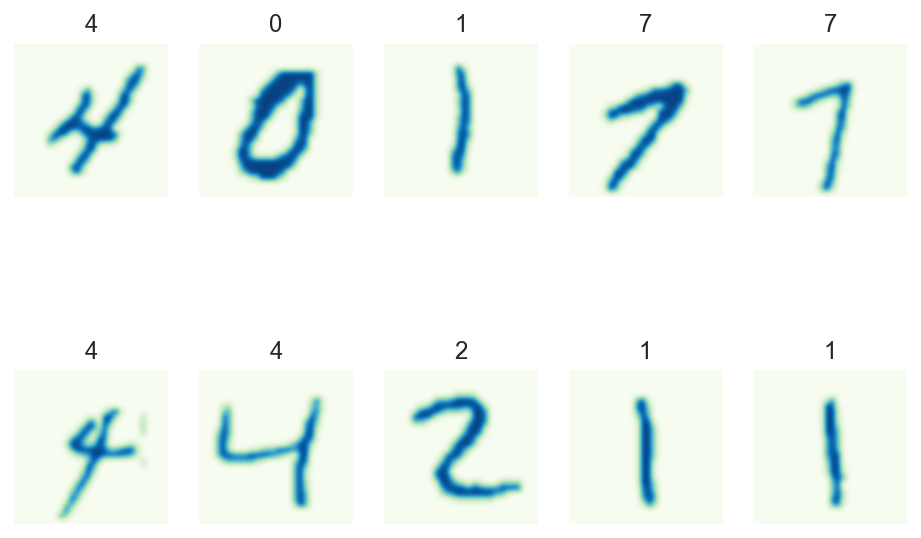

In [8]:
(row, col) = (2, 5)

fig, axes = plt.subplots(nrows=row, ncols=col)
plt.figure(figsize=(16,9))

for i in range(row):
    for j in range(col):
        currGen = allData[ random.randint(0, len(data)-1) ]
        axes[i][j].imshow(currGen[0], cmap=mpl.cm.GnBu, interpolation="bicubic")
        axes[i][j].set_title( str(currGen[1]) )
        
        axes[i][j].xaxis.label.set_visible(False)
        axes[i][j].axes.get_xaxis().set_visible(False)
        axes[i][j].axes.get_yaxis().set_visible(False)

In [9]:
# # pd.DataFrame(data[0:6000])
# data = np.array(data)
# data

# Logistic Regression
### sigmoid function
$f(x)=\frac{1}{1+e^{-x}}$

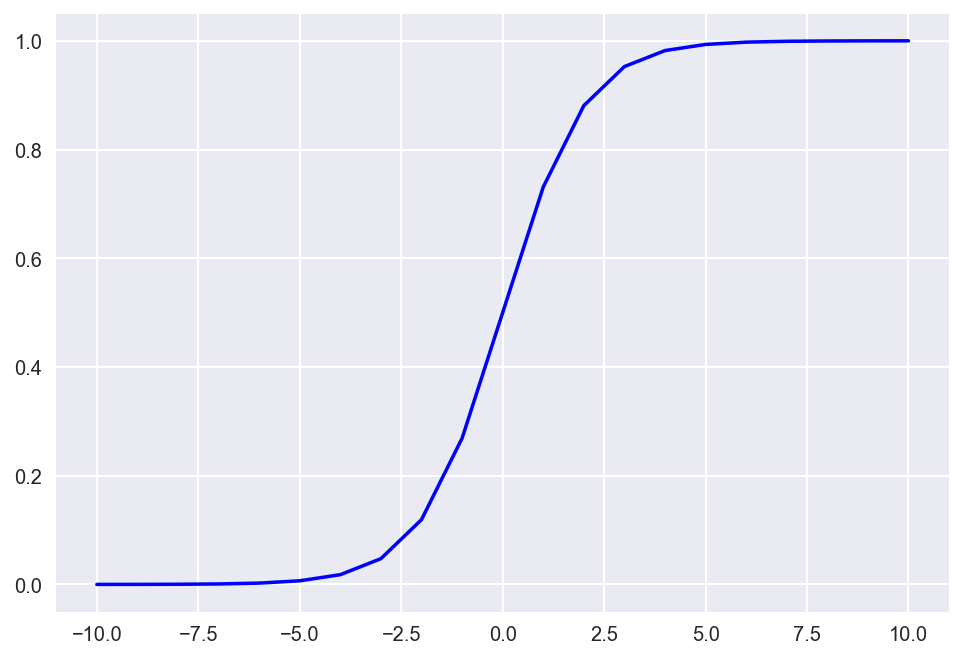

In [10]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

tempX = np.array(range(-10,11))
tempY = list( map(sigmoid, tempX) )
plt.plot(tempX, tempY, 'b')

In [11]:
def cost(theta, x, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(x)
    y = np.matrix(y)
    left = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    right = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = ( learningRate / (2 * len(X)) ) * np.sum( np.power(theta[:,1:theta.shape[1]], 2) )
    return np.sum(left - right) / (len(X)) + reg

In [12]:
def gradient(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])

    return grad

In [23]:
def workerFunc( args ):
    x, y, landa, label = args
    x0 = np.zeros( (x.shape[1],1) )
    print( [1 if yy == label else 0 for yy in y] )
    res = opt.minimize(cost, x0,jac=gradient, method='BFGS', args=(x, [ 1 if yy == label else 0 for yy in y], landa), options={'disp': True})
    print(label, "compelete!")
    return res.x
    return num
    
def findAllThatas(x, y, labels, landa=0.0001):
    p = Pool( len(labels) )
    return p.map(workerFunc, [ (x, y, landa, label) for label in labels ])

thetas = findAllThatas(x, y, [0,1,2,3,4,5,6,7,8,9])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 

In [14]:
def passProbability(theta, image):
    tmp = np.array(image) / 255.
    return sigmoid( np.dot(tmp, theta) )

In [15]:
PP = 0
for j in range(100):

    resP = 0
    resX = None
    for i in [(zzz, passProbability( thetas[zzz], x.iloc[j])) for zzz in range(10)]:
        if i[1] > resP:
            resP = i[1]
            resX = i[0]
    
    if y[j] == resX:
        PP += 1
        
print( PP )

14


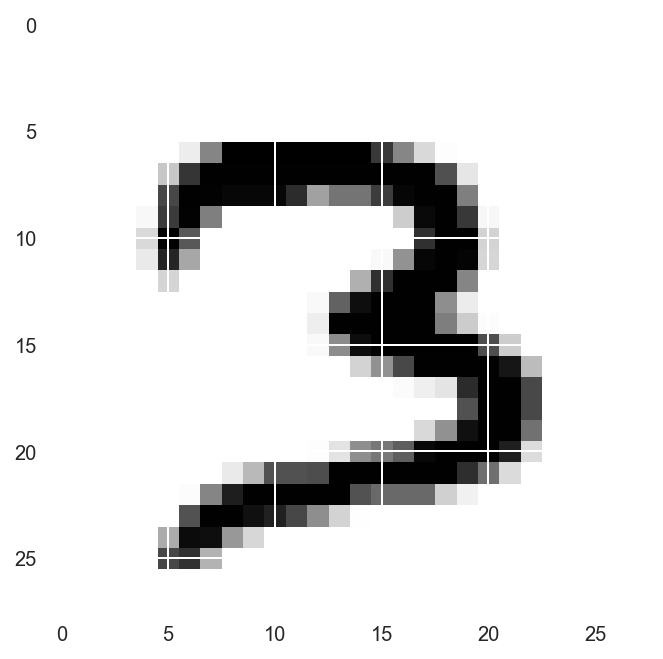

predicted probability for value  0  is:  0.18683691213
predicted probability for value  1  is:  0.197116474042
predicted probability for value  2  is:  0.10633407391
predicted probability for value  3  is:  0.16554776073
predicted probability for value  4  is:  0.165547760723
predicted probability for value  5  is:  0.0929643424069
predicted probability for value  6  is:  0.165547760739
predicted probability for value  7  is:  0.154479190466
predicted probability for value  8  is:  0.131297023612
predicted probability for value  9  is:  0.165547760727
---
predicted value is:  1
real value is:  3


In [22]:
with open("data/training_set_labels", 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    lbl_test = np.fromfile(flbl, dtype=np.int8)

with open("data/training_set_images", 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img_test_view = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl_test),rows,cols)
    img_test = img_test_view.reshape(len(lbl_test),rows*cols)

img_test = img_test/255.
img_test = np.concatenate((np.ones((1,len(lbl_test))), img_test.T)).T

idx_test = random.randint(0,len(lbl_test))
plt.imshow(img_test_view[idx_test], cmap='gray_r')
plt.show()
          
ans = sigmoid(np.dot(thetas,img_test[idx_test].T))
for i in range(0,10):
    print( "predicted probability for value ",i," is: ",ans[i] )
print("---")
print("predicted value is: " , ans.argmax())
print("real value is: ",lbl_test[idx_test])